In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from pandas_datareader import data as pdr
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns

In [19]:
# Fetch historical data for BYD stock
ticker_symbol = 'BYDDF'  # Ticker symbol for BYD Company Limited on OTC markets
data = yf.download(ticker_symbol, start="2015-01-01", end="2024-01-01")

# Calculate relevant variables
# 1. Daily Returns and Binary Increase Indicator
data['Daily_Returns'] = data['Adj Close'].pct_change()
data['Price_Increase'] = (data['Daily_Returns'] > 0).astype(int)

# 2. Volume
# Already included in the dataset as 'Volume'

# 3. Volatility (rolling 21-day standard deviation of daily returns)
data['Volatility'] = data['Daily_Returns'].rolling(window=21).std()

# 4. Moving Averages (10-day and 50-day)
data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
data['MA_50'] = data['Adj Close'].rolling(window=50).mean()

# 5. Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

# Drop NaN values created by moving averages and RSI calculation
data = data.dropna()

# Display the first few rows of the prepared dataset
print(data.head())

[*********************100%%**********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close  Volume  Daily_Returns  \
Date                                                                    
2015-03-16  4.62  4.66  4.60   4.65   4.598840   86100       0.024229   
2015-03-17  4.66  4.68  4.64   4.66   4.608729   22000       0.002150   
2015-03-18  4.86  4.92  4.86   4.92   4.865869   60500       0.055794   
2015-03-19  4.98  5.06  4.98   5.06   5.004329  222300       0.028455   
2015-03-20  5.04  5.04  4.98   4.98   4.925209   36800      -0.015810   

            Price_Increase  Volatility     MA_10     MA_50        RSI  
Date                                                                   
2015-03-16               1    0.046296  4.541478  3.995155  55.752234  
2015-03-17               1    0.044283  4.556313  4.006430  59.813082  
2015-03-18               1    0.025353  4.596862  4.024034  69.767477  
2015-03-19               1    0.024877  4.625542  4.043616 

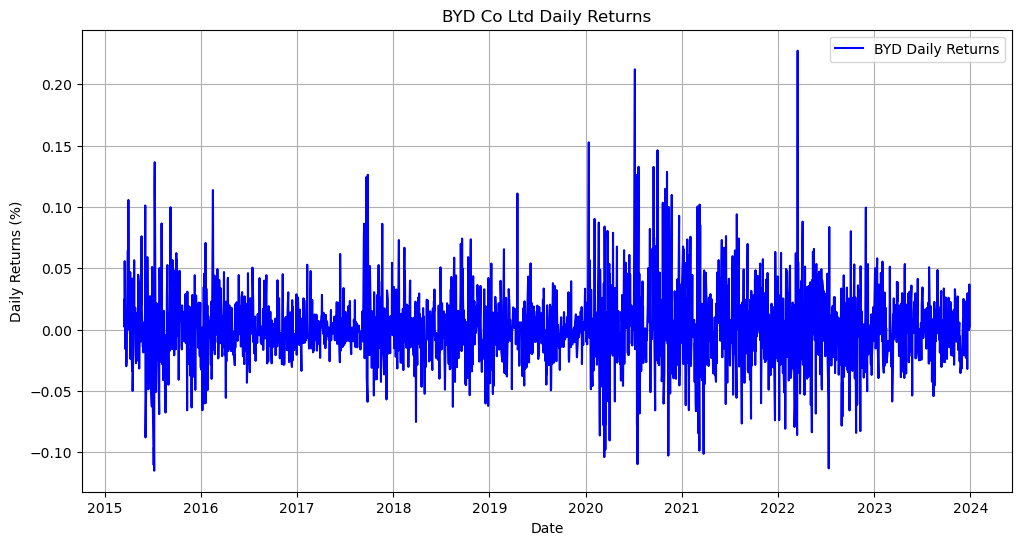

In [20]:
# Plot the daily returns
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Daily_Returns'], label='BYD Daily Returns', color='blue')
plt.title('BYD Co Ltd Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()
plt.grid(True)
plt.show()

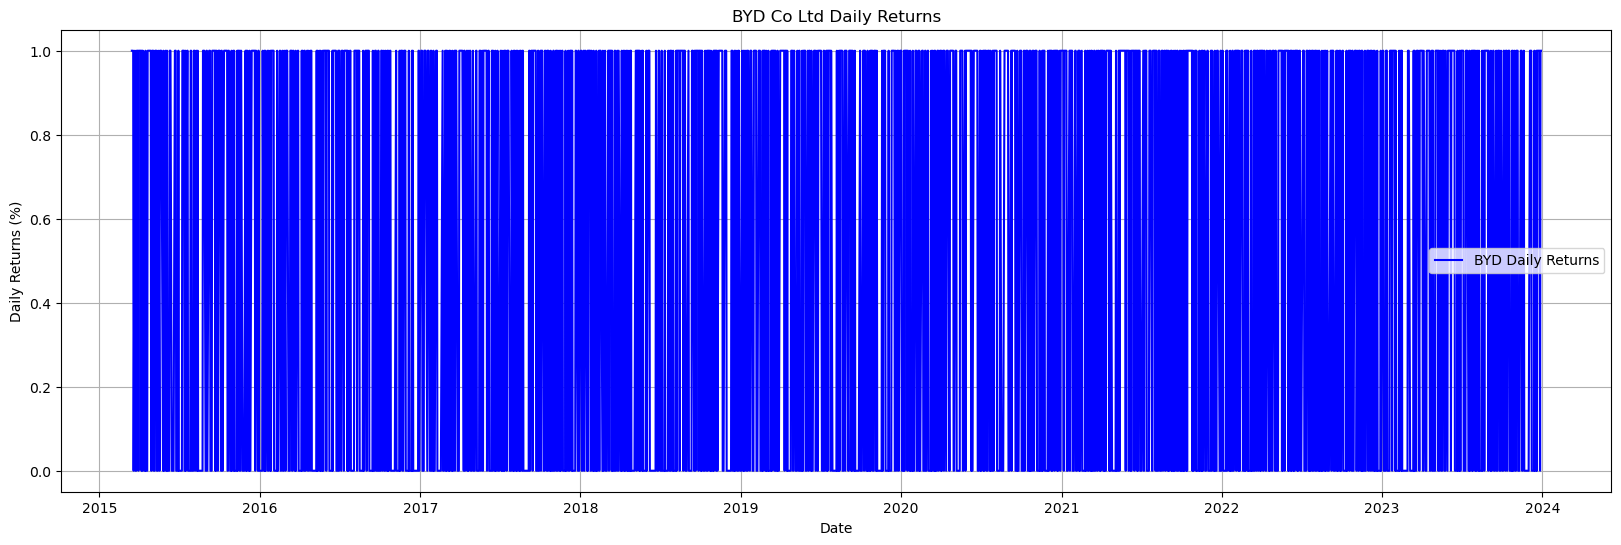

In [21]:
# Plot the daily returns
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['Price_Increase'], label='BYD Daily Returns', color='blue')
plt.title('BYD Co Ltd Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import yfinance as yf

# Fetching data for SP500, VIX, and DRIV
sp500_data = yf.download('^GSPC', start="2015-01-01", end="2024-01-01")  # S&P 500
vix_data = yf.download('^VIX', start="2015-01-01", end="2024-01-01")      # VIX
driv_data = yf.download('DRIV', start="2015-01-01", end="2024-01-01")     # DRIV ETF

# Calculating daily returns for SP500 and DRIV
sp500_data['SP500_Returns'] = sp500_data['Adj Close'].pct_change()
driv_data['DRIV_Returns'] = driv_data['Adj Close'].pct_change()

# Preparing the main dataset
# Note: The main dataset is assumed to be the 'data' variable with BYD stock information

# Merge SP500, VIX, and DRIV data with the BYD data
data = data.join(sp500_data['SP500_Returns']).join(vix_data['Adj Close'].rename('VIX')).join(driv_data['DRIV_Returns'])

# Drop NaN values that may have been created due to different trading days
data = data.dropna()

# Now 'data' contains BYD stock data, SP500 returns, VIX values, and DRIV returns
print(data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close   Volume  Daily_Returns  \
Date                                                                     
2018-04-18  7.67  7.67  7.53   7.57   7.486713   141300      -0.046599   
2018-04-19  7.69  7.70  7.59   7.64   7.555943   435700       0.009247   
2018-04-20  7.64  7.64  7.44   7.44   7.358144  1654500      -0.026178   
2018-04-23  7.40  7.51  7.40   7.42   7.338364    67300      -0.002688   
2018-04-24  7.48  7.60  7.48   7.55   7.466933    84200       0.017520   

            Price_Increase  Volatility     MA_10     MA_50        RSI  \
Date                                                                    
2018-04-18               0    0.026386  7.821983  8.729092  37.106918   
2018-04-19               1    0.026371  7.801214  8.702

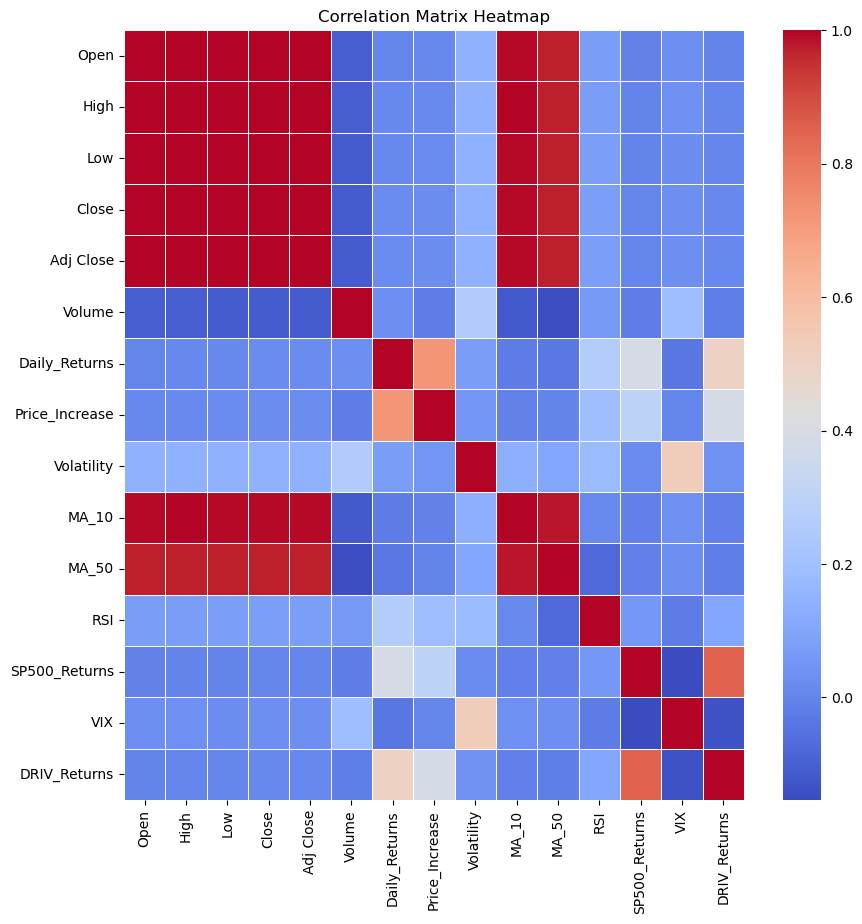

In [23]:
cor_matrix = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor_matrix,annot=False,cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [24]:
formula = 'Price_Increase ~ + MA_50 + RSI + SP500_Returns + VIX'

In [25]:
import statsmodels.formula.api as smf

# Assuming 'data' is your DataFrame with all the relevant variables including SP500 and VIX
# Probit Model
probit_model = smf.probit(formula, data=data).fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.624044
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:         Price_Increase   No. Observations:                 1436
Model:                         Probit   Df Residuals:                     1431
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                 0.09951
Time:                        17:21:01   Log-Likelihood:                -896.13
converged:                       True   LL-Null:                       -995.16
Covariance Type:            nonrobust   LLR p-value:                 9.800e-42
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.9625      0.160     -6.019      0.000      -1.276      -0.649
MA_50             0.

In [26]:
# Logit Model
logit_model = smf.logit(formula, data=data).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.623422
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         Price_Increase   No. Observations:                 1436
Model:                          Logit   Df Residuals:                     1431
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                  0.1004
Time:                        17:21:01   Log-Likelihood:                -895.23
converged:                       True   LL-Null:                       -995.16
Covariance Type:            nonrobust   LLR p-value:                 4.046e-42
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5949      0.265     -6.015      0.000      -2.115      -1.075
MA_50             0.

In [29]:
import itertools
import statsmodels.api as sm
import pandas as pd

# Assuming 'data' is your DataFrame and 'Price_Increase' is the dependent variable
independent_vars = ['MA_50', 'RSI', 'SP500_Returns', 'VIX', 'MA_10', 'DRIV_Returns']

# Preprocessing: Drop any rows with NaN values in these columns
data = data.dropna(subset=['Price_Increase'] + independent_vars)

# Generating all possible combinations of the independent variables
combinations = list(itertools.chain(*[itertools.combinations(independent_vars, r) for r in range(1, len(independent_vars) + 1)]))

results = []

# Iterate over each combination
for combo in combinations:
    X = sm.add_constant(data[list(combo)])
    y = data['Price_Increase']

    # Fit the probit model for this combination
    model = sm.Probit(y, X).fit(disp=0)
    pseudo_r_squared = model.prsquared

    # Store the result
    results.append((combo, pseudo_r_squared))

# Sort results by pseudo R-squared in descending order
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

# Display sorted results
for combo, pseudo_r_squared in sorted_results:
    print(f"Combination: {combo}, Pseudo R-squared: {pseudo_r_squared}")

Combination: ('MA_50', 'RSI', 'SP500_Returns', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.1540700358041619
Combination: ('MA_50', 'RSI', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.15367809712336544
Combination: ('MA_50', 'RSI', 'SP500_Returns', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.15183104942919934
Combination: ('MA_50', 'RSI', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.15138620927142066
Combination: ('MA_50', 'RSI', 'SP500_Returns', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14555701589844317
Combination: ('RSI', 'SP500_Returns', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.14545568481316795
Combination: ('RSI', 'SP500_Returns', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14543079499183154
Combination: ('MA_50', 'RSI', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14518146462953063
Combination: ('RSI', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.1450776493854351
Combination: ('RSI', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14505351235

In [30]:
import itertools
import statsmodels.api as sm
import pandas as pd

# Assuming 'data' is your DataFrame and 'Price_Increase' is the dependent variable
independent_vars = ['MA_50', 'RSI', 'SP500_Returns', 'VIX', 'MA_10', 'DRIV_Returns']

# Preprocessing: Drop any rows with NaN values in these columns
data = data.dropna(subset=['Price_Increase'] + independent_vars)

# Generating all possible combinations of the independent variables
combinations = list(itertools.chain(*[itertools.combinations(independent_vars, r) for r in range(1, len(independent_vars) + 1)]))

results = []

# Iterate over each combination
for combo in combinations:
    X = sm.add_constant(data[list(combo)])
    y = data['Price_Increase']

    # Fit the probit model for this combination
    model = sm.Probit(y, X).fit(disp=0)
    pseudo_r_squared = model.prsquared

    # Store the result
    results.append((combo, pseudo_r_squared))

# Sort results by pseudo R-squared in descending order
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

# Display sorted results
for combo, pseudo_r_squared in sorted_results:
    print(f"Combination: {combo}, Pseudo R-squared: {pseudo_r_squared}")

Combination: ('MA_50', 'RSI', 'SP500_Returns', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.1540700358041619
Combination: ('MA_50', 'RSI', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.15367809712336544
Combination: ('MA_50', 'RSI', 'SP500_Returns', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.15183104942919934
Combination: ('MA_50', 'RSI', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.15138620927142066
Combination: ('MA_50', 'RSI', 'SP500_Returns', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14555701589844317
Combination: ('RSI', 'SP500_Returns', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.14545568481316795
Combination: ('RSI', 'SP500_Returns', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14543079499183154
Combination: ('MA_50', 'RSI', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14518146462953063
Combination: ('RSI', 'VIX', 'MA_10', 'DRIV_Returns'), Pseudo R-squared: 0.1450776493854351
Combination: ('RSI', 'VIX', 'DRIV_Returns'), Pseudo R-squared: 0.14505351235

In [31]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
# Define your independent (X) and dependent (Y) variables
X = data[[ 'MA_10', 'VIX', 'RSI', 'SP500_Returns', 'DRIV_Returns']]
y = data['Price_Increase']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model on the training set
model = sm.Probit(y_train, X_train).fit()

# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred_label = (y_pred > 0.5).astype(int)  # Converting probabilities to binary outcomes

# You can then compare y_pred_label with y_test to evaluate the model's performance


Optimization terminated successfully.
         Current function value: 0.588182
         Iterations 6


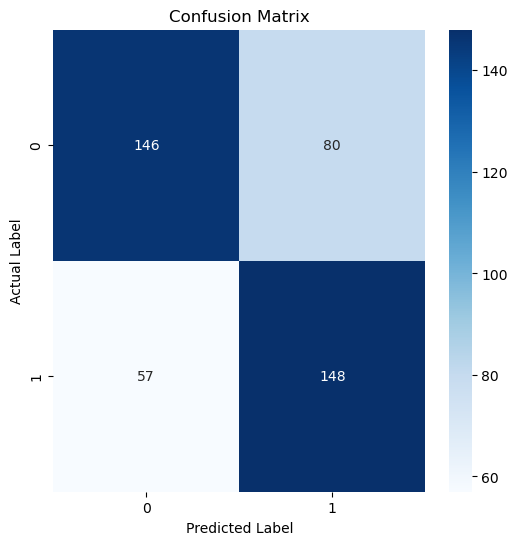

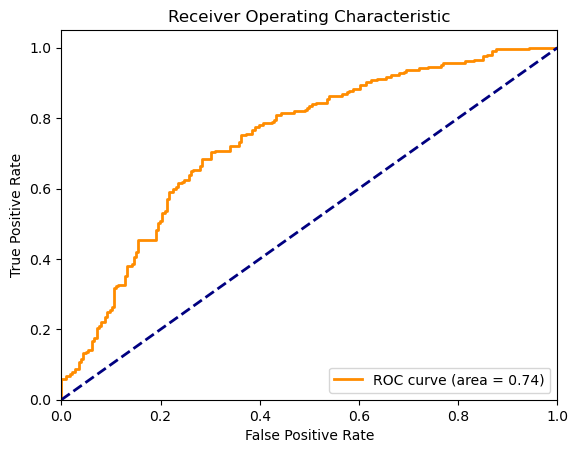

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# ... [previous code to split data and fit model]

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_label = (y_pred > 0.5).astype(int)  # Threshold at 0.5

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Optimization terminated successfully.
         Current function value: 0.588182
         Iterations 6


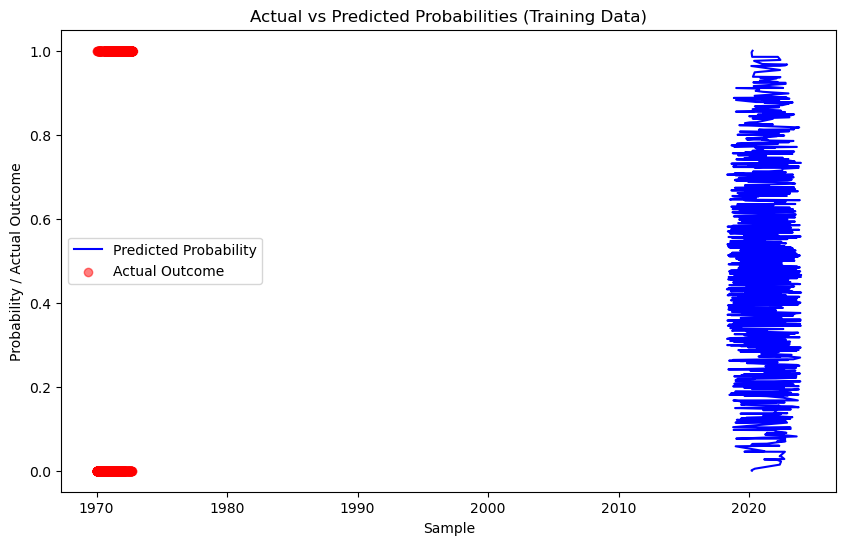

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Fit the model on the training set
model = sm.Probit(y_train, X_train).fit()

# Make predictions on the training set
y_train_pred_prob = model.predict(X_train)

# Sorting the values for a coherent plot
sorted_indices = np.argsort(y_train_pred_prob)
sorted_y_train_pred_prob = y_train_pred_prob[sorted_indices]
sorted_y_train = y_train.iloc[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_y_train_pred_prob, label='Predicted Probability', color='blue')
plt.scatter(range(len(sorted_y_train)), sorted_y_train, color='red', alpha=0.5, label='Actual Outcome')
plt.title('Actual vs Predicted Probabilities (Training Data)')
plt.xlabel('Sample')
plt.ylabel('Probability / Actual Outcome')
plt.legend()
plt.show()
